<a href="https://colab.research.google.com/github/bkkaggle/pytorch-CycleGAN-and-pix2pix/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Pix2Pix/')

Mounted at /content/drive


In [2]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import save_image
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define constants and hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 50
LOAD_MODEL = False
SAVE_MODEL = True
TRAINED_MODEL_DISC = "disc.pth.tar"
TRAINED_MODEL_GEN = "gen.pth.tar"
# Define transformations for both input and target images
both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)
# Define transformations for input image only
transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)
# Define transformations for target image only
transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [3]:

# Function to save some examples for visualization
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5
        save_image(y_fake, folder + f"/generated_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

# Function to save trained model
def save_trained_model(model, optimizer, filename="trained_model.pth.tar"):
    print("=> Saving trained model")
    trained_model = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(trained_model, filename)

# Function to load trained model
def load_trained_model(trained_model_file, model, optimizer, lr):
    print("=> Loading trained model")
    trained_model = torch.load(trained_model_file, map_location=DEVICE)
    model.load_state_dict(trained_model["state_dict"])
    optimizer.load_state_dict(trained_model["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [4]:

# Define dataset class for loading map data
class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:, 256:, :]
        target_image = image[:, :256, :]
        # Apply transformations to both input and target images
        augmentations = both_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image

In [5]:

# Define a custom Block class that inherits from PyTorch's nn.Module
class Block(nn.Module):
    # Initialize the block with input and output channels, a flag for downsampling,
    # activation function type, and a flag for using dropout
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        # Create a convolution layer with reflection padding for downsampling
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        # Set the dropout flag and create a dropout layer with 50% dropout rate
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down
    # Define the forward pass for the block
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

# Define a Generator class that inherits from PyTorch's nn.Module
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        # Define the initial downsampling layer
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        # Define the subsequent downsampling blocks
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        # Define the bottleneck convolution layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )
        # Define the upsampling blocks
        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        # Define the final upsampling layer
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    # Define the forward pass for the generator
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [6]:
# Define the CNNBlock class which represents a single block in the Convolutional Neural Network
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        # Define the sequential layers in the block
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
         # Pass the input through the convolutional layers
        return self.conv(x)

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
         # Define the initial layer
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )
        # Initialize layers list
        layers = []
        in_channels = features[0]
        # Iterate through features and create CNN blocks
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
        # Add the final layer
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        # Combine layers into a single sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        # Concatenate input images along the channel dimension
        x = torch.cat([x, y], dim=1)
        # Pass the combined input through the initial layer
        x = self.initial(x)
        # Pass the output from the initial layer through the rest of the model
        x = self.model(x)
        # Return the final output
        return x

In [7]:

# Set CuDNN benchmark for performance
torch.backends.cudnn.benchmark = True


# Define the train function
def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):
    # Initialize progress bar
    loop = tqdm(loader, leave=True)

    # Iterate through the dataset
    for idx, (x, y) in enumerate(loop):
        # Move input data to the device (e.g., GPU)
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            # Generate fake image using the generator
            y_fake = gen(x)
            # Calculate discriminator's output for real and fake images
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            # Calculate discriminator's loss
            D_loss = (D_real_loss + D_fake_loss) / 2

        # Update discriminator's gradients and parameters
        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            # Calculate generator's output
            D_fake = disc(x, y_fake)
            # Calculate generator's loss
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        # Update generator's gradients and parameters
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Update progress bar with current losses
        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

# Define the main training loop
def train():
    # Initialize discriminator and generator models, optimizers, loss functions, etc.
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_trained_model(
            TRAINED_MODEL_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_trained_model(
            TRAINED_MODEL_DISC, disc, opt_disc, LEARNING_RATE,
        )
    # Create training and validation datasets and data loaders
    train_dataset = MapDataset(root_dir=TRAIN_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    val_dataset = MapDataset(root_dir=VAL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    # Iterate through epochs
    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
        )

        if SAVE_MODEL and epoch % 5 == 0:
            save_trained_model(gen, opt_gen, filename=TRAINED_MODEL_GEN)
            save_trained_model(disc, opt_disc, filename=TRAINED_MODEL_DISC)

        save_some_examples(gen, val_loader, epoch, folder="saved_results")

In [8]:
train()

100%|██████████| 25/25 [00:19<00:00,  1.31it/s, D_fake=0.344, D_real=0.602]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:05<00:00,  4.95it/s, D_fake=0.18, D_real=0.742]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:06<00:00,  3.80it/s, D_fake=0.233, D_real=0.751]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:05<00:00,  4.83it/s, D_fake=0.048, D_real=0.961]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:06<00:00,  3.83it/s, D_fake=0.125, D_real=0.912]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:05<00:00,  4.80it/s, D_fake=0.217, D_real=0.736]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:05<00:00,  4.68it/s, D_fake=0.178, D_real=0.892]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:06<00:00,  4.08it/s, D_fake=0.378, D_real=0.45]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:05<00:00,  4.82it/s, D_fake=0.554, D_real=0.335]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:06<00:00,  3.71it/s, D_fake=0.273, D_real=0.488]


=> Saving trained model
=> Saving trained model


100%|██████████| 25/25 [00:06<00:00,  3.74it/s, D_fake=0.34, D_real=0.699]


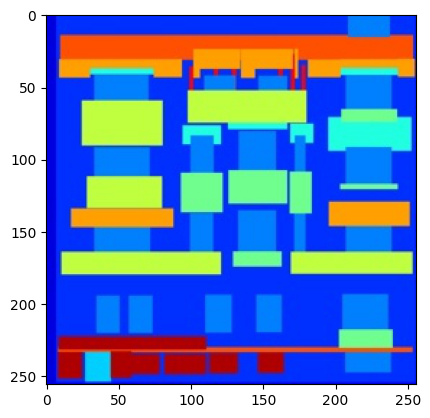

In [9]:
import matplotlib.pyplot as plt

img = plt.imread('./saved_results/input_200.png')
plt.imshow(img)

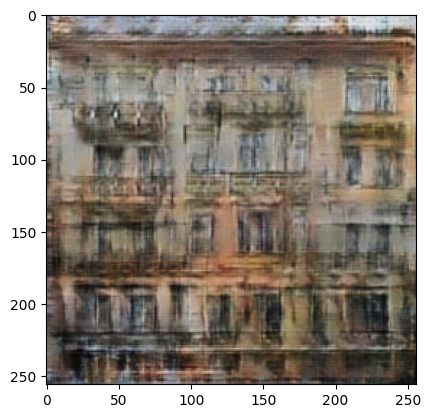

In [10]:
img = plt.imread('./saved_results/generated_200.png')
plt.imshow(img)